<a href="https://colab.research.google.com/github/Priyankaverma2024/Project-6-Pharmaceutical-Sales-prediction-solution-for-retail-stores/blob/main/ROSSMANN_STORE_SALES_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# mounted My Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define the path to the uploaded file
uploaded_file_path = '/content/drive/MyDrive/rossmann-store-sales.zip'
extracted_folder_path = '/content/drive/MyDrive/rossmann-store-sales'

# Extract the contents of the zip file
with zipfile.ZipFile(uploaded_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the extracted files to understand the structure
os.listdir(extracted_folder_path)

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

The extracted files from the dataset are:

train.csv: Likely contains the training data for model building.

test.csv: Likely contains the test data for predictions.

store.csv: Possibly contains additional metadata about the stores.

sample_submission.csv: May provide a template for submission or expected output format.

In [ ]:
# Load the training data

train_file_path = os.path.join(extracted_folder_path, 'train.csv')
train_data = pd.read_csv(train_file_path)

# Display basic information and the first few rows of the training data

train_data.info(), train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


(None,
    Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
 0      1          5  2015-07-31   5263        555     1      1            0   
 1      2          5  2015-07-31   6064        625     1      1            0   
 2      3          5  2015-07-31   8314        821     1      1            0   
 3      4          5  2015-07-31  13995       1498     1      1            0   
 4      5          5  2015-07-31   4822        559     1      1            0   
 
    SchoolHoliday  
 0              1  
 1              1  
 2              1  
 3              1  
 4              1  )

The train.csv dataset contains 1,017,209 entries with the following columns:

Store: Identifier for the store.

DayOfWeek: Day of the week (1=Monday, 7=Sunday).

Date: Date of the entry.

Sales: Sales for that store on the given day (target variable).

Customers: Number of customers visiting the store.

Open: Whether the store was open (1) or closed (0).

Promo: Whether a promotion was active (1) or not (0).

StateHoliday: Whether the day was a state holiday (0 = None, 'a', 'b', 'c').

SchoolHoliday: Whether it was a school holiday (1 or 0).

Some observations:

Date is a string and should be converted to a datetime format.

StateHoliday has mixed types (likely categorical data).

In [ ]:
#  Next, we will preview the test.csv file to understand its structure and ensure alignment with the training data.

In [ ]:
# Load the test data

test_file_path = os.path.join(extracted_folder_path, 'test.csv')
test_data = pd.read_csv(test_file_path)

# Display basic information and the first few rows of the test data

test_data.info(), test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


(None,
    Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
 0   1      1          4  2015-09-17   1.0      1            0              0
 1   2      3          4  2015-09-17   1.0      1            0              0
 2   3      7          4  2015-09-17   1.0      1            0              0
 3   4      8          4  2015-09-17   1.0      1            0              0
 4   5      9          4  2015-09-17   1.0      1            0              0)

The test.csv dataset contains 41,088 entries with the following columns:

Id: Unique identifier for each entry (likely for submission).

Store: Store identifier.

DayOfWeek: Day of the week (1=Monday, 7=Sunday).

Date: Date of the entry.

Open: Whether the store was open (1), closed (0), or missing.

Promo: Whether a promotion was active (1 or 0).

StateHoliday: Whether the day was a state holiday.

SchoolHoliday: Whether it was a school holiday (1 or 0).


#  Key Observations:

The target variable (Sales) is missing in this dataset, as it is the one to predict.

The Open column has some missing values.

To proceed, we will:

Join additional store information (from store.csv).
Preprocess both datasets (e.g., handle dates, encode categorical variables, and fill missing values).
Build and evaluate a predictive model for Sales

In [ ]:
# Load the store information data

store_file_path = os.path.join(extracted_folder_path, 'store.csv')
store_data = pd.read_csv(store_file_path)

# Display basic information and the first few rows of the store data

store_data.info(), store_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


(None,
    Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
 0      1         c          a               1270.0                        9.0   
 1      2         a          a                570.0                       11.0   
 2      3         a          a              14130.0                       12.0   
 3      4         c          c                620.0                        9.0   
 4      5         a          a              29910.0                        4.0   
 
    CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
 0                    2008.0       0              NaN              NaN   
 1                    2007.0       1             13.0           2010.0   
 2                    2006.0       1             14.0           2011.0   
 3                    2009.0       0              NaN              NaN   
 4                    2015.0       0              NaN              NaN   
 
      PromoInterval  
 0              NaN  
 1  Jan,A

In [ ]:
# Load the sample submission information data
sample_submission_file_path = os.path.join(extracted_folder_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_file_path)

 Display basic information and the first few rows of the store data

sample_submission.info(), sample_submission.head()

# Merge Store Data
#  Joint store.csv with both train and test datasets:

In [ ]:
#  MERGE TRAIN DATA WITH STORE DATA
train = train_data.merge(store_data, on='Store', how='left')
# MERGE TEST DATA WITH STORE DATA
test = test_data.merge(store_data, on='Store', how='left')

# Preprocess the Data
Convert the Date column to a datetime format:

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

   Extract date-related features:

In [ ]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.isocalendar().week
train['DayOfWeek'] = train['Date'].dt.dayofweek
train['IsHoliday'] = train['StateHoliday'].apply(lambda x :1 if x !='0' else 0)

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['WeekOfYear'] = test['Date'].dt.isocalendar().week
test['DayOfWeek'] = test['Date'].dt.dayofweek
test['IsHoliday'] = test['StateHoliday'].apply(lambda x :1 if x !='0' else 0)

Fill missing values:

In [ ]:
train['Open'].fillna(1, inplace=True)  # Assuming stores are open by default
test['Open'].fillna(1, inplace=True)

In [ ]:
train.isnull().sum(),test.isnull().sum()

(Store                             0
 DayOfWeek                         0
 Date                              0
 Sales                             0
 Customers                         0
 Open                              0
 Promo                             0
 StateHoliday                      0
 SchoolHoliday                     0
 StoreType                         0
 Assortment                        0
 CompetitionDistance            2642
 CompetitionOpenSinceMonth    323348
 CompetitionOpenSinceYear     323348
 Promo2                            0
 Promo2SinceWeek              508031
 Promo2SinceYear              508031
 PromoInterval                508031
 Year                              0
 Month                             0
 Day                               0
 WeekOfYear                        0
 IsHoliday                         0
 dtype: int64,
 Id                               0
 Store                            0
 DayOfWeek                        0
 Date                     

In [ ]:
train['CompetitionDistance'].fillna(train['CompetitionDistance'].median(), inplace=True)
test['CompetitionDistance'].fillna(test['CompetitionDistance'].median(), inplace=True)

In [ ]:
train['PromoInterval'].fillna("None", inplace=True)
test['PromoInterval'].fillna("None", inplace=True)

In [ ]:
train['Promo2SinceWeek'].fillna(0, inplace=True)
test['Promo2SinceWeek'].fillna(0, inplace=True)

In [ ]:
# Replace remaining missing values after specific handling:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)


Validate

Recheck missing values to ensure everything is filled:

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
IsHoliday                    0
dtype: int64
Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                 

In [ ]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int32         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

(None, None)

Handle Outliers

Outliers are extreme values that can adversely impact model performance. We'll focus on key features like Sales, Customers, and CompetitionDistance.

In [ ]:
# Calculate IQR for Sales
Q1 = train['Sales'].quantile(0.25)
Q3 = train['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train[(train['Sales'] < Q1 - 1.5 * IQR) | (train['Sales'] > Q3 + 1.5 * IQR)]
print(f"Number of Sales outliers: {len(outliers)}")

Number of Sales outliers: 26694


 Handle Outliers
Options to handle outliers:

Clip Values: Limit extreme values to a threshold.

In [ ]:
train['Sales'] = np.clip(train['Sales'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

Remove Outliers:

In [ ]:
train = train[~((train['Sales'] < Q1 - 1.5 * IQR) | (train['Sales'] > Q3 + 1.5 * IQR))]

In [ ]:
# Customers, and CompetitionDistance.
# Calculate IQR for Sales
Q1 = train['Customers'].quantile(0.25)
Q3 = train['Customers'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train[(train['Customers'] < Q1 - 1.5 * IQR) | (train['Customers'] > Q3 + 1.5 * IQR)]
print(f"Number of Customers outliers: {len(outliers)}")

Number of Customers outliers: 38095


In [ ]:
train['Customers'] = np.clip(train['Customers'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
# Outliers removed
train = train[~((train['Customers'] < Q1 - 1.5 * IQR) | (train['Customers'] > Q3 + 1.5 * IQR))]

In [ ]:
# Calculate IQR for Store
Q1 = train['Store'].quantile(0.25)
Q3 = train['Store'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train[(train['Store'] < Q1 - 1.5 * IQR) | (train['Store'] > Q3 + 1.5 * IQR)]
print(f"Number of Store outliers: {len(outliers)}")

Number of Store outliers: 0


In [ ]:
# Calculate IQR for CompetitionDistance
Q1 = train['CompetitionDistance'].quantile(0.25)
Q3 = train['CompetitionDistance'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train[(train['CompetitionDistance'] < Q1 - 1.5 * IQR) | (train['CompetitionDistance'] > Q3 + 1.5 * IQR)]
print(f"Number of competitionDistance outliers: {len(outliers)}")

Number of competitionDistance outliers: 99160


In [ ]:
train['CompetitionDistance'] = np.clip(train['CompetitionDistance'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
# Outliers removed
train = train[~((train['CompetitionDistance'] < Q1 - 1.5 * IQR) | (train['CompetitionDistance'] > Q3 + 1.5 * IQR))]

In [ ]:
# Calculate IQR for test data's Competition distance
Q1 = test['CompetitionDistance'].quantile(0.25)
Q3 = test['CompetitionDistance'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = test[(test['CompetitionDistance'] < Q1 - 1.5 * IQR) | (test['CompetitionDistance'] > Q3 + 1.5 * IQR)]
print(f"Number of ComptitionDistance outliers: {len(outliers)}")

Number of ComptitionDistance outliers: 3792


In [ ]:
test['CompetitionDistance'] = np.clip(test['CompetitionDistance'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
# Outliers removed
test = test[~((test['CompetitionDistance'] < Q1 - 1.5 * IQR) | (test['CompetitionDistance'] > Q3 + 1.5 * IQR))]

In [ ]:
# Calculate IQR for test data's Competition distance outliers removed
Q1 = test['CompetitionDistance'].quantile(0.25)
Q3 = test['CompetitionDistance'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = test[(test['CompetitionDistance'] < Q1 - 1.5 * IQR) | (test['CompetitionDistance'] > Q3 + 1.5 * IQR)]
print(f"Number of ComptitionDistance outliers: {len(outliers)}")

Number of ComptitionDistance outliers: 0


# EDA
# Exploratory Data Visualiztion

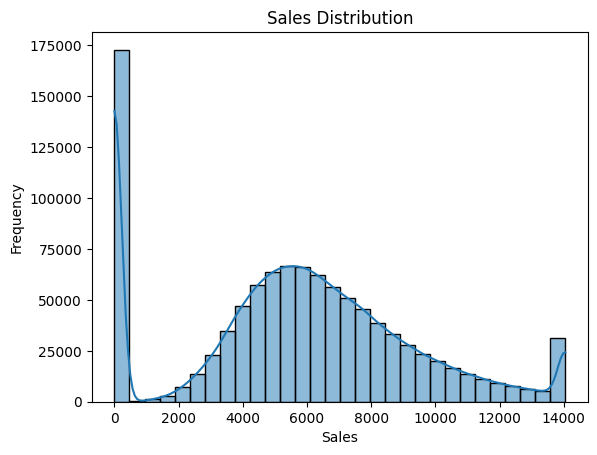

In [ ]:
sns.histplot(train['Sales'], kde=True, bins=30)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

above plot is shown sales distribution through the histogram using bins . here we can ese the sales frquency up's and down's .

zero sales frequency is very high may be stores are close or holiday   

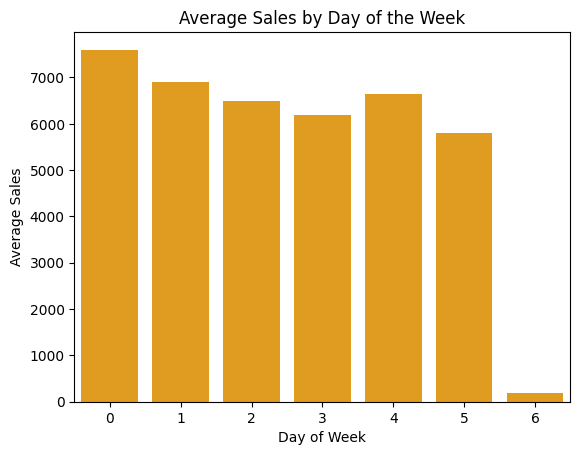

In [ ]:
avg_sales_by_day = train.groupby('DayOfWeek')['Sales'].mean()
sns.barplot(x=avg_sales_by_day.index, y=avg_sales_by_day.values,color='orange')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()

Above barplot is shown the average sales between a week .

As i can see that maximum  average sales are  shown in mondays then gradually it will decreases and suddenly on friday it goes up again but on sunday it shows minimum average sales accros the week .May be ti happends due to holiday and stores may be closed on that days .

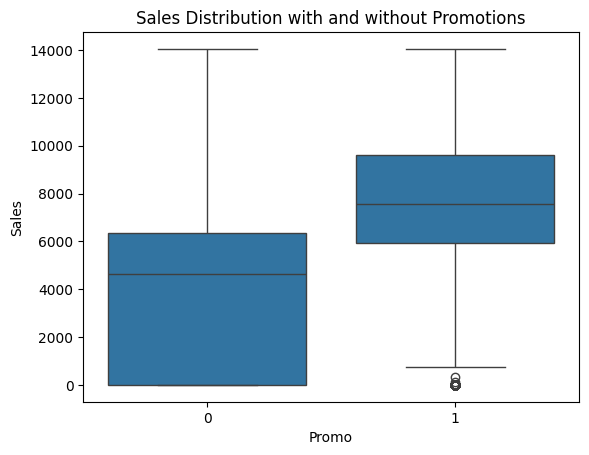

In [ ]:
sns.boxplot(x=train['Promo'], y=train['Sales'])
plt.title('Sales Distribution with and without Promotions')
plt.xlabel('Promo')
plt.ylabel('Sales')
plt.show()

Above boxplot is shown highest sale on promotional periods .
It is good way to attract more customers and achive high sales as compare to non promotional days


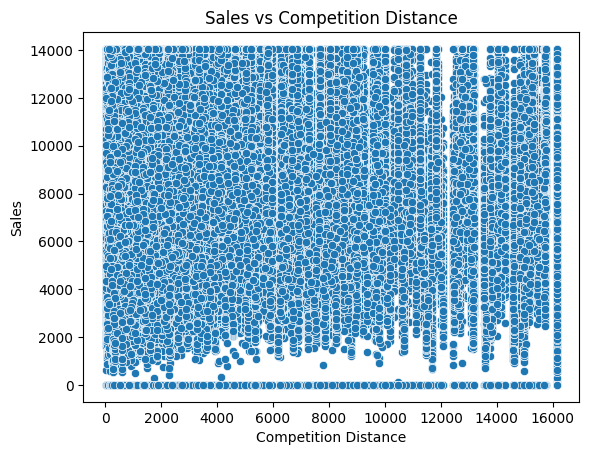

In [ ]:
sns.scatterplot(x=train['CompetitionDistance'], y=train['Sales'])
plt.title('Sales vs Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Sales')
plt.show()

Above scatter plot is use to show the relation between sales and compitiopn distance but the above output is not showing any perfect relation ship between them

# TASK 1 ANALYSIS QUESTIONS

Compare the distribution of promotions across training and test sets.

In [ ]:
# Training set promo distribution
train_promo_dist = train['Promo'].value_counts(normalize=True) * 100

# Test set promo distribution
test_promo_dist = test['Promo'].value_counts(normalize=True) * 100

print("Promo Distribution in Training Set (%):\n", train_promo_dist)
print("\nPromo Distribution in Test Set (%):\n", test_promo_dist)

Promo Distribution in Training Set (%):
 Promo
0    61.848548
1    38.151452
Name: proportion, dtype: float64

Promo Distribution in Test Set (%):
 Promo
0    60.416667
1    39.583333
Name: proportion, dtype: float64


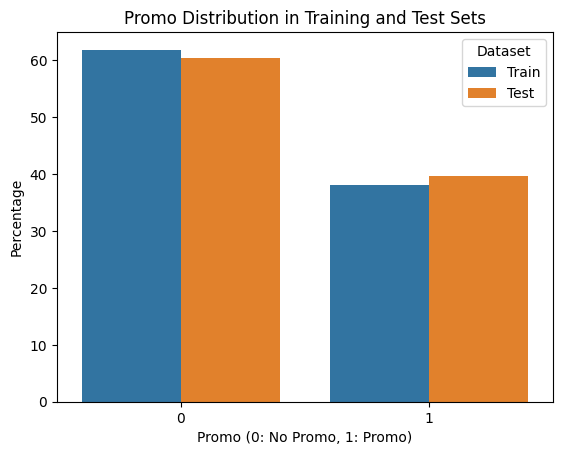

In [ ]:
# Combine promo data for visualization
promo_dist = pd.DataFrame({
    'Dataset': ['Train'] * len(train_promo_dist) + ['Test'] * len(test_promo_dist),
    'Promo': train_promo_dist.index.tolist() + test_promo_dist.index.tolist(),
    'Percentage': train_promo_dist.tolist() + test_promo_dist.tolist()
})

# Plot
sns.barplot(data=promo_dist, x='Promo', y='Percentage', hue='Dataset')
plt.title('Promo Distribution in Training and Test Sets')
plt.xlabel('Promo (0: No Promo, 1: Promo)')
plt.ylabel('Percentage')
plt.show()

Training and testing data both have 60 to 61 % data shows non promotional status and 38 to 39 % is shown promotional status

Analyze Sales Trends Around Holidays

This involves identifying sales patterns
before, during, and after holidays.

Step 1: Extract Holiday Periods

Use the StateHoliday column in the dataset to identify holiday-related sales.

Step 2: Aggregate Sales by Holiday Period
Summarize average sales by HolidayPeriod:

Step 3: Visualize Trends

Plot the average sales for each period:

In [ ]:


# Add a 'HolidayFlag' for analysis
train['HolidayFlag'] = train['StateHoliday'].apply(lambda x: 1 if x != '0' else 0)

# Identify sales before, during, and after holidays (7-day window)
train['HolidayPeriod'] = 'Non-Holiday'
train.loc[train['HolidayFlag'] == 1, 'HolidayPeriod'] = 'During Holiday'
train.loc[(train['Date'] + pd.Timedelta(days=7)).isin(train.loc[train['HolidayFlag'] == 1, 'Date']), 'HolidayPeriod'] = 'Post-Holiday'
train.loc[(train['Date'] - pd.Timedelta(days=7)).isin(train.loc[train['HolidayFlag'] == 1, 'Date']), 'HolidayPeriod'] = 'Pre-Holiday'

In [ ]:
holiday_sales = train.groupby('HolidayPeriod')['Sales'].mean()
print(holiday_sales)

HolidayPeriod
During Holiday     250.755764
Non-Holiday       5771.691844
Post-Holiday      6470.224558
Pre-Holiday       5891.658123
Name: Sales, dtype: float64


During the holiday period sales goes very low and after holiday it becomes high uptil 6470/-as compare to non holidays and pre holidays .

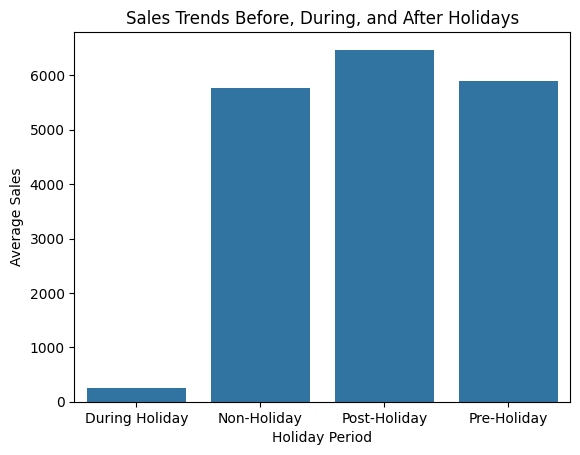

In [ ]:
sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.title('Sales Trends Before, During, and After Holidays')
plt.xlabel('Holiday Period')
plt.ylabel('Average Sales')
plt.show()

During the holiday period sales goes very low 250.75/-and after holiday it becomes high uptil 6470.22/-as compare to non holidays and pre holidays .

# Investigate Seasonal Purchasing Patterns
Focus on specific holidays like Christmas and Easter to uncover trends.

Step 1: Flag Seasonal Events
Manually define key holidays (e.g., Christmas, Easter):

Step 2: Aggregate Sales by Season
Compute total or average sales for each season:
Step 3: Visualize Seasonal Patterns
Create a bar plot for sales by season:

In [ ]:
# Add a 'Season' column
train['Season'] = 'Regular'
train.loc[(train['Date'].dt.month == 12) & (train['Date'].dt.day >= 20), 'Season'] = 'Christmas'
train.loc[(train['Date'].dt.month==11,'Season')] = 'Diwali'   # Adjust for Easter range as needed
train.loc[train['Date'].dt.month == 4, 'Season'] = 'Easter'  # Adjust for Easter range as needed

In [ ]:
# Compute total or average sales for each season:
season_sales = train.groupby('Season')['Sales'].mean()
print(season_sales)


Season
Christmas    5173.781301
Diwali       5929.983350
Easter       5656.427544
Regular      5692.570245
Name: Sales, dtype: float64


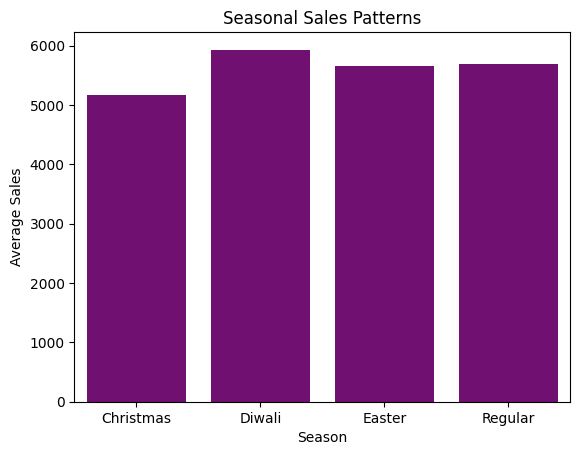

In [ ]:
# Create a bar plot for sales by season:
sns.barplot(x=season_sales.index, y=season_sales.values,color='purple')
plt.title('Seasonal Sales Patterns')
plt.xlabel('Season')
plt.ylabel('Average Sales')
plt.show()

Above barplot is shown the high average sales on Diwali .It is a key holiday that lie between Nowember first week and this time weather conditions are affect humans due to winters  similarly it is also seems like christmas month that is december and peak of winters as compare to regular months. But on Easter this time starts summer this will continue till the june same as regular sales   

# Examine Trends Over Time

Analyze monthly or weekly trends for additional seasonal insights.


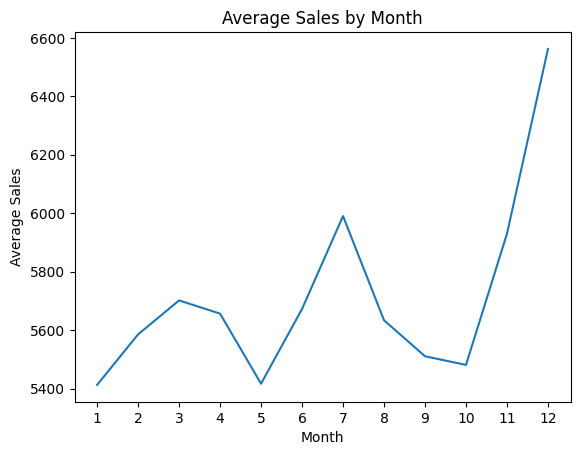

In [ ]:
# monthly trend
train['Date'] = pd.to_datetime(train['Date'])
train['Month'] = train['Date'].dt.month
monthly_sales = train.groupby('Month')['Sales'].mean()

sns.lineplot(x=monthly_sales.index, y=monthly_sales.values,palette='viridis')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.show()

Above lineplot is shown march,july Nov,December are  shown hikes in average sales
Maximum 6600 average sales are touched in November to december  

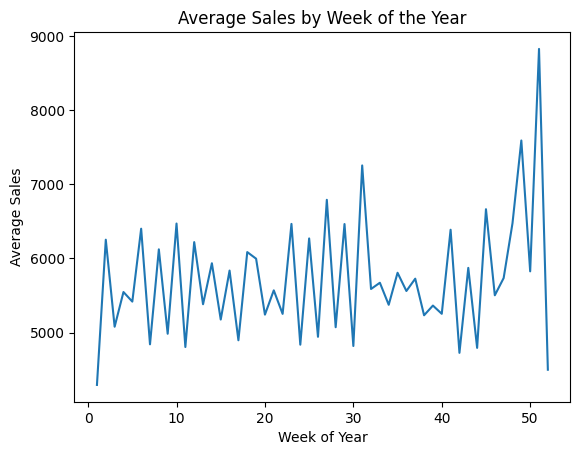

In [ ]:
# weekly trend
train['WeekOfYear'] = train['Date'].dt.isocalendar().week
weekly_sales = train.groupby('WeekOfYear')['Sales'].mean()

sns.lineplot(x=weekly_sales.index, y=weekly_sales.values)
plt.title('Average Sales by Week of the Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Sales')
plt.show()

#   As per above **lineplot weekly** sales shown a similar trends .

 To understand the sales pattern it will help positively for prediction goal .

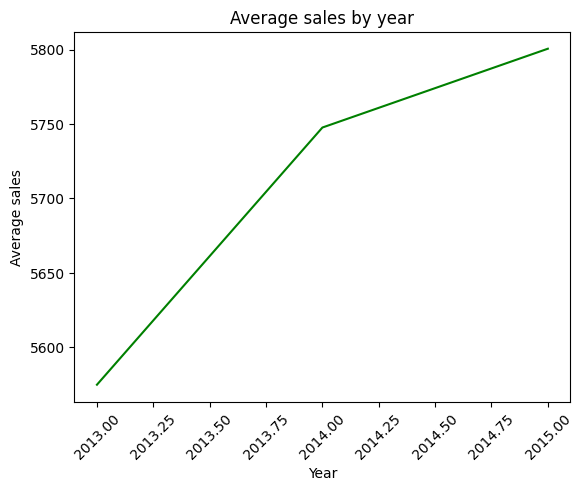

In [ ]:
# yearly  trend
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year


year_sales = train.groupby(train['Year'])['Sales'].mean()

sns.lineplot(x=year_sales.index, y=year_sales.values,color='green')
plt.title('Average sales by year')
plt.xlabel('Year')
plt.ylabel('Average sales')
plt.xticks(rotation=45)
plt.show()



As per above line plot we have 3 years data as 2013 to 2015   

 year 2015 shows highest sales  

 Total Sales On number of Stores

In [ ]:
sales_by_store = train.groupby('Store')['Sales'].sum().sort_values(ascending=False)
print(sales_by_store.head(10))

Store
262     13232859.5
562     13129525.0
733     12920951.5
1114    10993998.5
788     10977983.0
335     10971360.5
513     10952700.5
817     10943902.0
251     10919037.5
383     10886551.0
Name: Sales, dtype: float64


Monthly Sales In dscending order with  

In [ ]:
train['Month'] = train['Date'].dt.month
monthly_sales = train.groupby('Month')['Sales'].sum().sort_values(ascending=False)
print(monthly_sales)

Month
3     591222044.5
7     587734878.0
6     569210482.5
4     567622504.0
5     561662600.5
1     561230118.5
2     523111115.5
12    417034292.5
11    364693976.0
8     358021695.0
10    348310836.0
9     338890921.0
Name: Sales, dtype: float64




**Trends of Sales Based on Store Opening/Closing Times**

Step 1: Analyze Sales When Stores Are Closed

Separate and summarize sales when stores are open (Open = 1) versus closed (Open = 0).

Step 2: Visualize Sales by Store Status

In [ ]:
# Group sales by store status (open/closed)
open_sales = train.groupby('Open')['Sales'].mean()

print(f"Average Sales When Open: {open_sales.get(1, 0)}")
print(f"Average Sales When Closed: {open_sales.get(0, 0)}")

Average Sales When Open: 6855.519076447906
Average Sales When Closed: 0.0


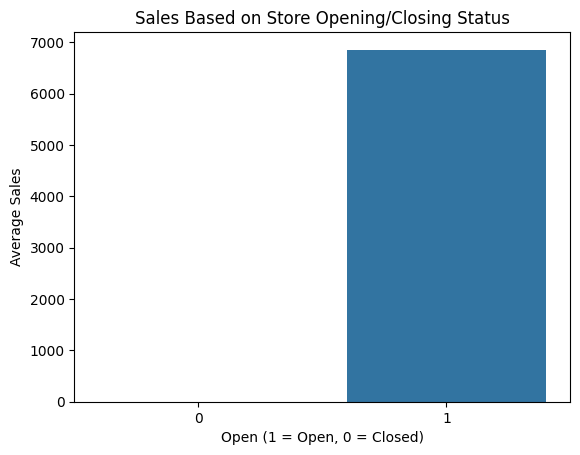

In [ ]:
#  visualize sales by store status

sns.barplot(x=open_sales.index, y=open_sales.values)
plt.title('Sales Based on Store Opening/Closing Status')
plt.xlabel('Open (1 = Open, 0 = Closed)')
plt.ylabel('Average Sales')
plt.show()

when stores are open then average sales goes upto 7000/-

As stores are close then  sales is zero  

**Correlation Between Sales and Customer Numbers**

Step 1: Calculate Correlation

Use Pearson's correlation to assess the relationship between sales and customer numbers:

In [ ]:
correlation = train[['Sales', 'Customers']].corr().iloc[0, 1]
print(f"Correlation between Sales and Customer Numbers: {correlation}")

Correlation between Sales and Customer Numbers: 0.9208048531996348


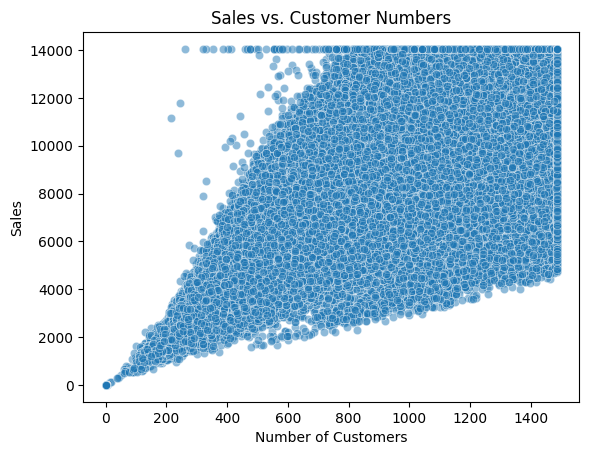

In [ ]:
# Visualize the Relationship
# Create a scatter plot to show the relationship:

sns.scatterplot(x='Customers', y='Sales', data=train, alpha=0.5)
plt.title('Sales vs. Customer Numbers')
plt.xlabel('Number of Customers')
plt.ylabel('Sales')
plt.show()

Insights to Look For:
A strong positive correlation indicates higher sales with more customers.

**Evaluate the Impact of Promotions on Customer Behavior**

Step 1: Compare Customer Numbers with and without Promotions

Summarize average customer counts for promotional and non-promotional days:

Step 2: Visualize the Impact of Promotions

In [ ]:
promo_customer_counts = train.groupby('Promo')['Customers'].mean()

print(f"Average Customers with Promo: {promo_customer_counts.get(1, 0)}")
print(f"Average Customers without Promo: {promo_customer_counts.get(0, 0)}")

Average Customers with Promo: 790.6382936507937
Average Customers without Promo: 500.44177903100956


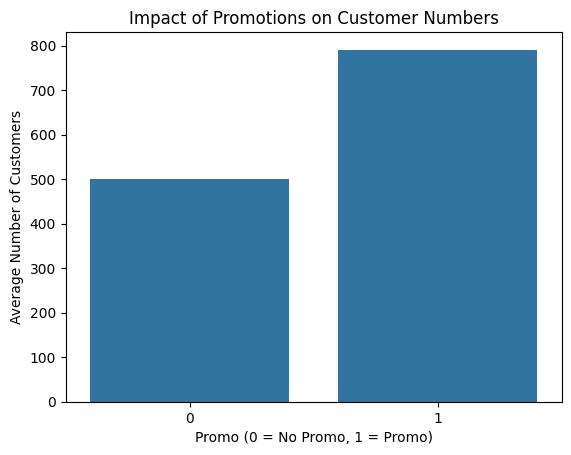

In [ ]:
# Step 2: Visualize the Impact of Promotions

sns.barplot(x=promo_customer_counts.index, y=promo_customer_counts.values)
plt.title('Impact of Promotions on Customer Numbers')
plt.xlabel('Promo (0 = No Promo, 1 = Promo)')
plt.ylabel('Average Number of Customers')
plt.show()

Insight : customer strength depends on promotions if promo is active no.of customers 790.63 customers visited stores but without promo only 500.44 customer visited the store  

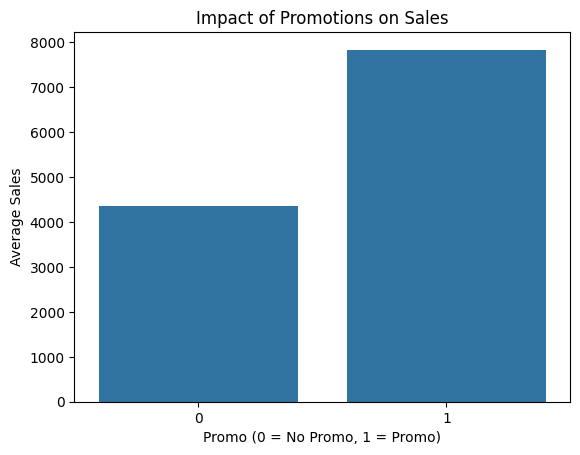

In [ ]:
# Assessment of Sales with and without Promotions

promo_sales = train.groupby('Promo')['Sales'].mean()

sns.barplot(x=promo_sales.index, y=promo_sales.values)
plt.title('Impact of Promotions on Sales')
plt.xlabel('Promo (0 = No Promo, 1 = Promo)')
plt.ylabel('Average Sales')
plt.show()


insigth: Sales also affected by promo when promo is active or on we can see a higher sales because that time maximum customers visite our stores .

**Increased customer numbers during promotions indicate the success of promotional campaigns**

#  Effect of Competitor Distance on Store Sales

Step 1: Group Sales by Competitor Distance

Group stores by competitor distance ranges to evaluate sales:

In [ ]:
# Create distance bins
train['CompetitionDistanceBin'] = pd.cut(
    train['CompetitionDistance'],
    bins=[0, 1000, 5000, 10000, 20000, float('inf')],
    labels=['0-1k', '1k-5k', '5k-10k', '10k-20k', '>20k']
)

# Calculate average sales for each bin
distance_sales = train.groupby('CompetitionDistanceBin')['Sales'].mean()
print(distance_sales)


CompetitionDistanceBin
0-1k       5911.864423
1k-5k      5596.504822
5k-10k     5544.436648
10k-20k    5645.062455
>20k               NaN
Name: Sales, dtype: float64


Compititor distance  not very much affected they allmost gradualy shown decreased sales according to number of kilometers increased .

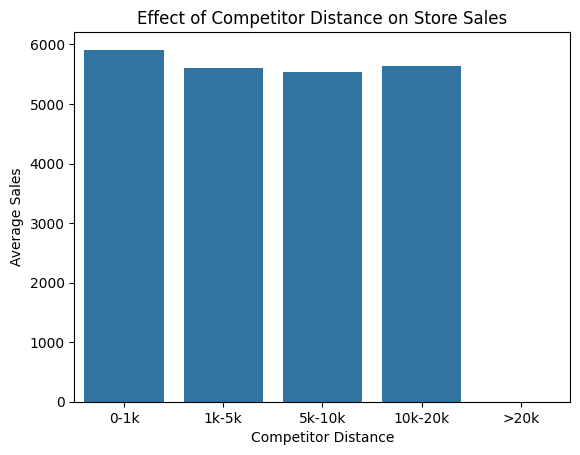

In [ ]:
sns.barplot(x=distance_sales.index, y=distance_sales.values)
plt.title('Effect of Competitor Distance on Store Sales')
plt.xlabel('Competitor Distance')
plt.ylabel('Average Sales')
plt.show()

Insights to Look For:
Do stores closer to competitors have significantly lower sales?
Is there a threshold beyond which competitor distance no longer impacts sales?

**Influence of Assortment Types on Sales**

Step 1: Summarize Sales by Assortment Type

Analyze the Assortment column, which indicates the variety of products available at the store. Group average sales by assortment type:

In [ ]:
# Check unique assortment types
print(train['Assortment'].unique())

# Calculate average sales by assortment type
assortment_sales = train.groupby('Assortment')['Sales'].mean()
print(assortment_sales)

['a' 'c' 'b']
Assortment
a    5417.717468
b    8373.314866
c    5954.932500
Name: Sales, dtype: float64


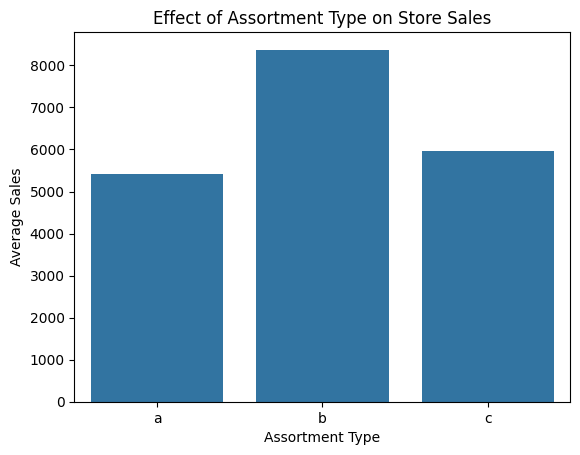

In [ ]:
# visualize the effect
sns.barplot(x=assortment_sales.index, y=assortment_sales.values)
plt.title('Effect of Assortment Type on Store Sales')
plt.xlabel('Assortment Type')
plt.ylabel('Average Sales')
plt.show()

insight : only  'b' type Assortment is having max sales then 'c' and 'a'

Combined Analysis: Competitor Distance vs. Assortment Type

Explore how competitor distance and assortment type interact to influence sales:

Statistical Testing

For deeper analysis, test if differences in sales across groups (e.g., different assortment types or distance bins) are statistically significant.

Test for Assortment Sales Differences

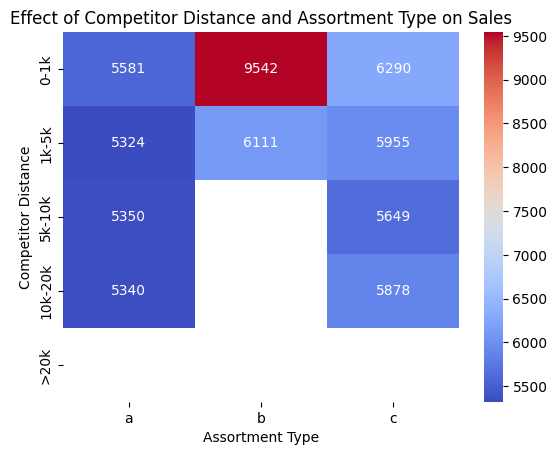

In [ ]:
# Group sales by both competitor distance and assortment type
distance_assortment_sales = train.groupby(['CompetitionDistanceBin', 'Assortment'])['Sales'].mean().unstack()

# Plot heatmap to visualize the interaction
sns.heatmap(distance_assortment_sales, annot=True, fmt=".0f", cmap="coolwarm")
plt.title('Effect of Competitor Distance and Assortment Type on Sales')
plt.xlabel('Assortment Type')
plt.ylabel('Competitor Distance')
plt.show()

insight : Above heatmap is shown b type assortment that having 0 - 1k comptitor distance is got maximum 9542 sales as compare to other one .
may be it will give us more clera view if we have some extra detail's of assortment product types etc.

4. Statistical Testing

For deeper analysis, test if differences in sales across groups (e.g., different assortment types or distance bins) are statistically significant.

Test for Assortment Sales Differences

The f_oneway function from the scipy.stats module is used to perform one-way Analysis of Variance (ANOVA). This statistical test is applied when you want to compare the means of two or more independent groups to determine if there are significant differences among them.

The main purpose of ANOVA is to test the null hypothesis that the means of several groups are equal.


In [ ]:
from scipy.stats import f_oneway

# Perform ANOVA for sales across assortment types
assortment_a = train[train['Assortment'] == 'A']['Sales']
assortment_b = train[train['Assortment'] == 'B']['Sales']
assortment_c = train[train['Assortment'] == 'C']['Sales']
#from scipy.stats import f_oneway

# Perform ANOVA for sales across assortment types
#assortment_a = train[train['Assortment'] == 'A']['Sales']
#assortment_b = train[train['Assortment'] == 'B']['Sales']
#assortment_c = train[train['Assortment'] == 'C']['Sales']

anova_result = f_oneway(assortment_a, assortment_b, assortment_c)
print(f"ANOVA p-value for assortment type differences: {anova_result.pvalue}")

ANOVA p-value for assortment type differences: nan


The kruskal function from the scipy.stats module is used to perform the Kruskal-Wallis H test, which is a non-parametric alternative to one-way ANOVA. This test is used to determine if there are significant differences between the medians of two or more independent groups.

In [ ]:
# Test for Competitor Distance Sales Differences

# Perform Kruskal-Wallis test for sales across distance bins

from scipy.stats import kruskal
distance_bins = [train[train['CompetitionDistanceBin'] == bin]['Sales'] for bin in train['CompetitionDistanceBin'].cat.categories]
kruskal_result = kruskal(*distance_bins)
print(f"Kruskal-Wallis p-value for distance bin differences: {kruskal_result.pvalue}")


Kruskal-Wallis p-value for distance bin differences: nan


A low p-value (< 0.05) indicates statistically significant differences in sales across the groups.

In [ ]:
train.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Year,Month,Day,WeekOfYear,IsHoliday,HolidayFlag,HolidayPeriod,Season,CompetitionDistanceBin
0,1,4,2015-07-31,5263.0,555,1,1,0,1,c,...,None,2015,7,31,31,0,0,Non-Holiday,Regular,1k-5k
1,2,4,2015-07-31,6064.0,625,1,1,0,1,a,...,"Jan,Apr,Jul,Oct",2015,7,31,31,0,0,Non-Holiday,Regular,0-1k
2,3,4,2015-07-31,8314.0,821,1,1,0,1,a,...,"Jan,Apr,Jul,Oct",2015,7,31,31,0,0,Non-Holiday,Regular,10k-20k
3,4,4,2015-07-31,13995.0,1485,1,1,0,1,c,...,None,2015,7,31,31,0,0,Non-Holiday,Regular,0-1k
4,5,4,2015-07-31,4822.0,559,1,1,0,1,a,...,None,2015,7,31,31,0,0,Non-Holiday,Regular,10k-20k


In [ ]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,1017209.0,558.429727,1.0,280.0,558.0,838.0,1115.0,321.908651
DayOfWeek,1017209.0,2.998341,0.0,1.0,3.0,5.0,6.0,1.997391
Date,1017209,2014-04-11 01:30:42.846061824,2013-01-01 00:00:00,2013-08-17 00:00:00,2014-04-02 00:00:00,2014-12-12 00:00:00,2015-07-31 00:00:00,NaN
Sales,1017209.0,5690.812276,0.0,3727.0,5744.0,7856.0,14049.5,3595.807489
Customers,1017209.0,611.155962,0.0,405.0,609.0,837.0,1485.0,388.620282
Open,1017209.0,0.830107,0.0,1.0,1.0,1.0,1.0,0.375539
Promo,1017209.0,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759
SchoolHoliday,1017209.0,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056
CompetitionDistance,1017209.0,4647.337007,20.0,710.0,2330.0,6880.0,16135.0,5194.909985
CompetitionOpenSinceMonth,1017209.0,4.926878,0.0,0.0,4.0,9.0,12.0,4.283543


# Preprocessing
This step involves converting categorical data, handling missing values, scaling numeric data, and engineering new features.

Step 1: Convert Categorical Data to Numeric

Use label encoding or one-hot encoding based on the algorithm’s requirements.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Example for label encoding
categorical_columns = ['StoreType', 'Assortment','PromoInterval','StateHoliday']
for col in categorical_columns:
# Create a LabelEncoder instance outside the loop
    encoder = LabelEncoder()

    # Ensure all values are strings before encoding
    train[col] = train[col].astype(str)  # Convert to strings in train
    test[col] = test[col].astype(str)   # Convert to strings in test

    # Fit on training data and transform both train and test
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])



In [ ]:
  #   to save cleaned and encode train data
  #train.to_csv('train_cleaned_data.csv',index=False)

In [ ]:
# from google.colab import files
# To download  train data after preprocessing.
# files.download('train_cleaned_data.csv')

 # Scale Numerical Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year']
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

In [ ]:
#Generate Additional Features
#Feature engineering improves model performance:

#  Date-related features:

#train['Year'] = train['Date'].dt.year
#train['Month'] = train['Date'].dt.month
#train['Day'] = train['Date'].dt.day
#train['WeekOfYear'] = train['Date'].dt.isocalendar().week
#train['DayOfWeek'] = train['Date'].dt.dayofweek
train['IsWeekend'] = train['DayOfWeek'].isin([5, 6]).astype(int)
test['IsWeekend'] = test['DayOfWeek'].isin([5, 6]).astype(int)

In [ ]:
# Days to/from holidays
train['DaysToHoliday'] = (train['Date'] - train.loc[train['StateHoliday'] != '0', 'Date']).abs().dt.days
train['IsHoliday'] = train['StateHoliday'].apply(lambda x: 1 if x != '0' else 0)


In [ ]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Month,Day,WeekOfYear,IsHoliday,HolidayFlag,HolidayPeriod,Season,CompetitionDistanceBin,IsWeekend,DaysToHoliday
0,1,4,2015-07-31,5263.0,555,1,1,0,1,2,...,7,31,31,1,0,Non-Holiday,Regular,1k-5k,0,0
1,2,4,2015-07-31,6064.0,625,1,1,0,1,0,...,7,31,31,1,0,Non-Holiday,Regular,0-1k,0,0
2,3,4,2015-07-31,8314.0,821,1,1,0,1,0,...,7,31,31,1,0,Non-Holiday,Regular,10k-20k,0,0
3,4,4,2015-07-31,13995.0,1485,1,1,0,1,2,...,7,31,31,1,0,Non-Holiday,Regular,0-1k,0,0
4,5,4,2015-07-31,4822.0,559,1,1,0,1,0,...,7,31,31,1,0,Non-Holiday,Regular,10k-20k,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int32         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  float64       
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  int64         
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  int64         
 10  Assortment                 1017209 non-null  int64         
 11  CompetitionDistance        1017209 no

In [ ]:
#  Here  we need to prepare our train data which is merged  with store data according  to test data featuers
# we needd to drop that additional featuers


In [ ]:
train_data=train.drop(['HolidayFlag','HolidayPeriod','Season','CompetitionDistanceBin','Customers','StateHoliday','DaysToHoliday'],axis=1)

In [ ]:
train_data=train_data.drop(['Date'],axis=1)

In [ ]:
train_data.shape

(1017209, 21)

In [ ]:
train_data.isnull().sum()

,0
Store,0
DayOfWeek,0
Sales,0
Open,0
Promo,0
SchoolHoliday,0
StoreType,0
Assortment,0
CompetitionDistance,0
CompetitionOpenSinceMonth,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int32  
 2   Sales                      1017209 non-null  float64
 3   Open                       1017209 non-null  int64  
 4   Promo                      1017209 non-null  int64  
 5   SchoolHoliday              1017209 non-null  int64  
 6   StoreType                  1017209 non-null  int64  
 7   Assortment                 1017209 non-null  int64  
 8   CompetitionDistance        1017209 non-null  float64
 9   CompetitionOpenSinceMonth  1017209 non-null  float64
 10  CompetitionOpenSinceYear   1017209 non-null  float64
 11  Promo2                     1017209 non-null  int64  
 12  Promo2SinceWeek            1017209 non-null  float64
 13  Promo2SinceY

In [ ]:
train_data.describe()

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsHoliday,IsWeekend
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,...,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209.0,1017209.0,1.017209e+06
mean,5.584297e+02,2.998341e+00,5.690812e+03,8.301067e-01,3.815145e-01,1.786467e-01,1.207467e+00,9.351412e-01,6.250374e-17,4.926878e+00,...,5.005638e-01,4.545980e-17,8.228588e-18,1.978094e+00,1.392560e-13,5.846762e+00,1.570279e+01,23.615515,1.0,2.845630e-01
std,3.219087e+02,1.997391e+00,3.595807e+03,3.755392e-01,4.857586e-01,3.830564e-01,1.365376e+00,9.938011e-01,1.000000e+00,4.283543e+00,...,4.999999e-01,1.000000e+00,1.000000e+00,1.119589e+00,1.000000e+00,3.326097e+00,8.787638e+00,14.433381,0.0,4.512063e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.907448e-01,0.000000e+00,...,0.000000e+00,-7.600969e-01,-1.001128e+00,0.000000e+00,-1.070616e+00,1.000000e+00,1.000000e+00,1.0,1.0,0.000000e+00
25%,2.800000e+02,1.000000e+00,3.727000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.579225e-01,0.000000e+00,...,0.000000e+00,-7.600969e-01,-1.001128e+00,1.000000e+00,-1.070616e+00,3.000000e+00,8.000000e+00,11.0,1.0,0.000000e+00
50%,5.580000e+02,3.000000e+00,5.744000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.460786e-01,4.000000e+00,...,1.000000e+00,-6.948395e-01,9.961357e-01,2.000000e+00,2.157305e-01,6.000000e+00,1.600000e+01,22.0,1.0,0.000000e+00
75%,8.380000e+02,5.000000e+00,7.856000e+03,1.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,2.000000e+00,4.297792e-01,9.000000e+00,...,1.000000e+00,6.755670e-01,9.991181e-01,3.000000e+00,2.157305e-01,8.000000e+00,2.300000e+01,35.0,1.0,1.000000e+00
max,1.115000e+03,6.000000e+00,1.404950e+04,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,2.211332e+00,1.200000e+01,...,1.000000e+00,2.502776e+00,1.002101e+00,3.000000e+00,1.502077e+00,1.200000e+01,3.100000e+01,52.0,1.0,1.000000e+00


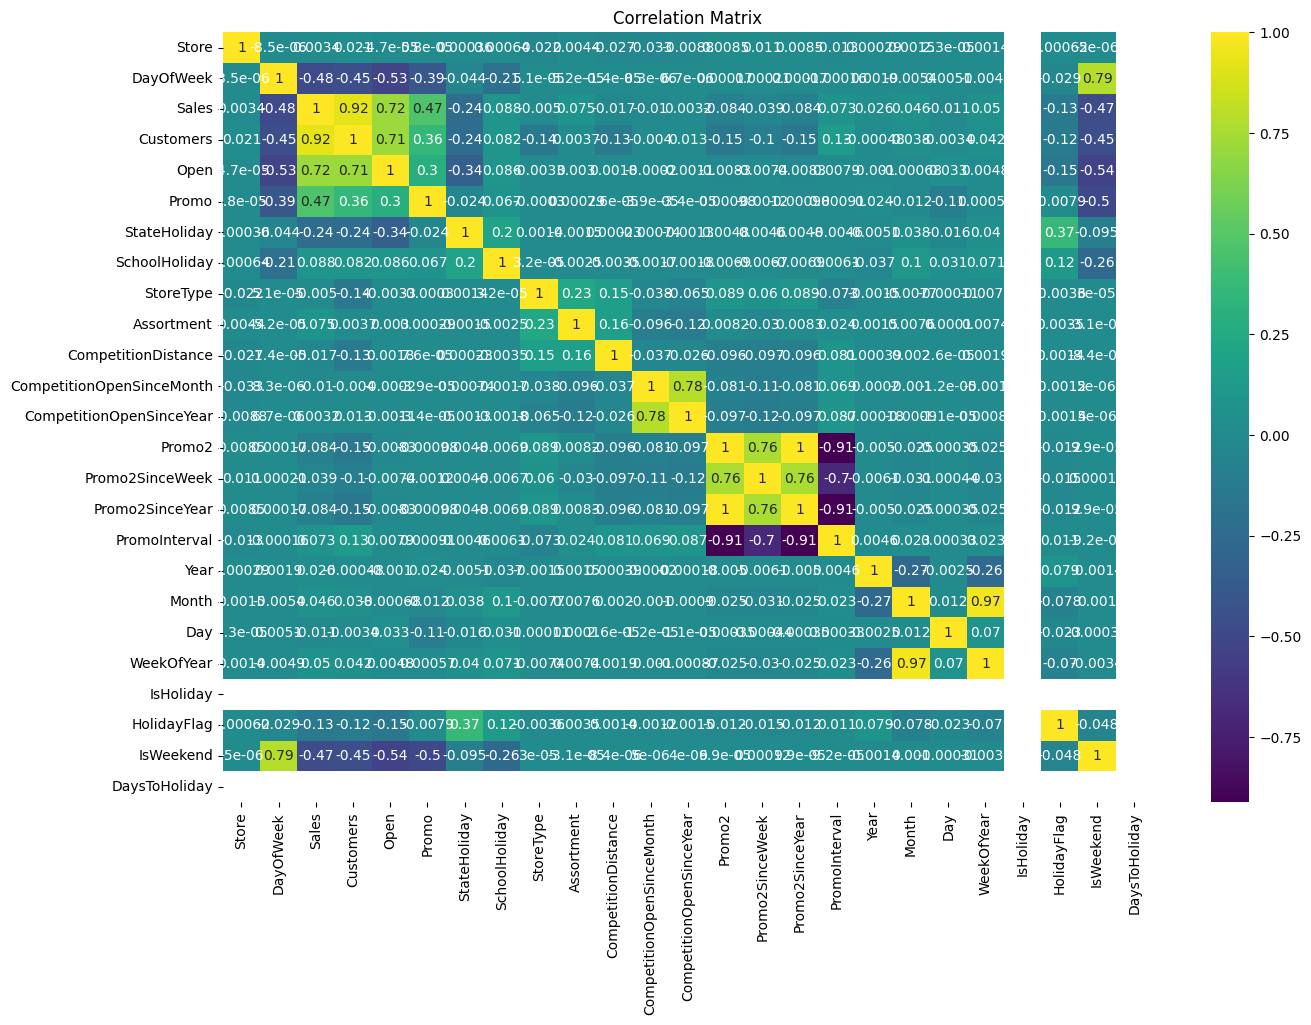

In [ ]:
# Select only numeric features for correlation analysis
numeric_features = train.select_dtypes(include=np.number).columns
correlation_matrix = train[numeric_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

promo,customers,dayofweek open schoolholiday,isweekend are positively correlated to sales and store columns  




In [ ]:
train_data.corr()

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsHoliday,IsWeekend
Store,1.000000,-0.000008,0.003404,-0.000047,0.000058,0.000641,-0.021604,0.004419,-0.026713,-0.032893,...,0.008488,0.011053,0.008520,-0.013325,0.000290,0.001467,0.000023,0.001421,NaN,-0.000005
DayOfWeek,-0.000008,1.000000,-0.481886,-0.528963,-0.392925,-0.205388,0.000051,-0.000052,-0.000014,0.000008,...,0.000168,0.000208,0.000168,-0.000155,0.001937,-0.005362,0.005136,-0.004880,NaN,0.789894
Sales,0.003404,-0.481886,1.000000,0.715977,0.468557,0.088484,-0.004961,0.074635,-0.016642,-0.010347,...,-0.084233,-0.038565,-0.084249,0.073209,0.025718,0.045805,-0.011411,0.050223,NaN,-0.473906
Open,-0.000047,-0.528963,0.715977,1.000000,0.295042,0.086171,-0.003325,0.002972,0.001830,-0.000200,...,-0.008309,-0.007436,-0.008308,0.007911,-0.001009,-0.000681,0.033428,0.004792,NaN,-0.537427
Promo,0.000058,-0.392925,0.468557,0.295042,1.000000,0.067483,-0.000299,0.000294,0.000076,-0.000039,...,-0.000983,-0.001210,-0.000983,0.000906,0.024300,-0.011747,-0.108325,0.000572,NaN,-0.495330
SchoolHoliday,0.000641,-0.205388,0.088484,0.086171,0.067483,1.000000,0.000032,-0.002530,-0.003466,-0.001688,...,-0.006909,-0.006679,-0.006912,0.006086,-0.036535,0.103282,0.030538,0.071052,NaN,-0.263140
StoreType,-0.021604,0.000051,-0.004961,-0.003325,-0.000299,0.000032,1.000000,0.232862,0.151735,-0.037799,...,0.088922,0.059704,0.088865,-0.073191,-0.001514,-0.007692,-0.000109,-0.007447,NaN,0.000030
Assortment,0.004419,-0.000052,0.074635,0.002972,0.000294,-0.002530,0.232862,1.000000,0.155622,-0.096244,...,0.008220,-0.030182,0.008267,0.023601,0.001494,0.007601,0.000104,0.007359,NaN,-0.000031
CompetitionDistance,-0.026713,-0.000014,-0.016642,0.001830,0.000076,-0.003466,0.151735,0.155622,1.000000,-0.037157,...,-0.095802,-0.097327,-0.095888,0.081071,0.000389,0.001980,0.000026,0.001917,NaN,-0.000008
CompetitionOpenSinceMonth,-0.032893,0.000008,-0.010347,-0.000200,-0.000039,-0.001688,-0.037799,-0.096244,-0.037157,1.000000,...,-0.081027,-0.108546,-0.080952,0.069280,-0.000203,-0.001037,-0.000012,-0.001004,NaN,0.000005


In [ ]:
train_data.skew()

,0
Store,-0.000955
DayOfWeek,0.001593
Sales,0.118171
Open,-1.758045
Promo,0.487838
SchoolHoliday,1.677842
StoreType,0.347269
Assortment,0.129988
CompetitionDistance,1.213586
CompetitionOpenSinceMonth,0.189174


skewness gives more clearly shown by the above numericl values which one is more positvely right skewed.

In [ ]:
# Before fitting the model, ensure all columns in X_train are numeric.

# 1. Identify columns with 'None' values:
for col in train_data.columns:
    if train_data[col].dtype == 'object':  # Check for object (string) columns
        if train_data[col].isin(['None']).any():
            print(f"Column '{col}' contains 'None' values.")

            train_data[col] = train_data[col].replace('None', np.nan)  # Replace 'None' with NaN
        try:
            train_data[col] = pd.to_numeric(train[col])  # Try converting to numeric

        except ValueError:
            print(f"Column '{col}' contains non-numeric values other than 'None'.")


# MODEL BUILDING

In [ ]:
# seprate featuers(X_train) and target variable(y_train)
X = train_data.drop(columns=['Sales'])
y = train_data['Sales']

In [ ]:
# split the data into training and validation sets
X_train, X_val, y_train,y_val = train_test_split(X,y,test_size=0.2 ,random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# creating  instance
dt_regressor = DecisionTreeRegressor(max_depth = 5,random_state=42)

# fit the regressor with X and y data
dt_regressor.fit(X_train,y_train)

# predict the model
y_pred = dt_regressor.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print('Root means quared error(rmse):',rmse)

Mean Squared Error (MSE): 4743156.147943222
R-squared (R2): 0.6326648004580417
Root means quared error(rmse): 2177.8788184706746


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Intialize the data into training and validation sets
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
rf_regressor.fit(X_train,y_train)

# Prediction on the validation set
y_pred = rf_regressor.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print('Root means quared error(rmse):',rmse)

Mean Squared Error (MSE): 551216.7128883305
R-squared (R2): 0.9573108506437218
Root means quared error(rmse): 742.4397032004218


# Justification of Loss function(MSE,R2 Score)


An MSE of 545116.60 shows the magnitude of the squared error. The large value might be due to the scale of your target variable
𝑦
y. If the target values are large (e.g., in the hundreds or thousands), then a higher MSE can still indicate good performance.
Justification:

MSE is differentiable, which is crucial for optimization during training.
It emphasizes large errors, helping the model minimize significant deviations between actual and predicted values.
Commonly used in regression tasks because it directly reflects the squared error, aligning with the typical objectives of predictive accuracy.

An R² of 0.9578 indicates that 95.78% of the variance in the target variable is explained by your model, which is excellent performance.
Justification:

R² complements MSE by providing a normalized measure of goodness-of-fit.
It helps in understanding how well the model generalizes to new data.

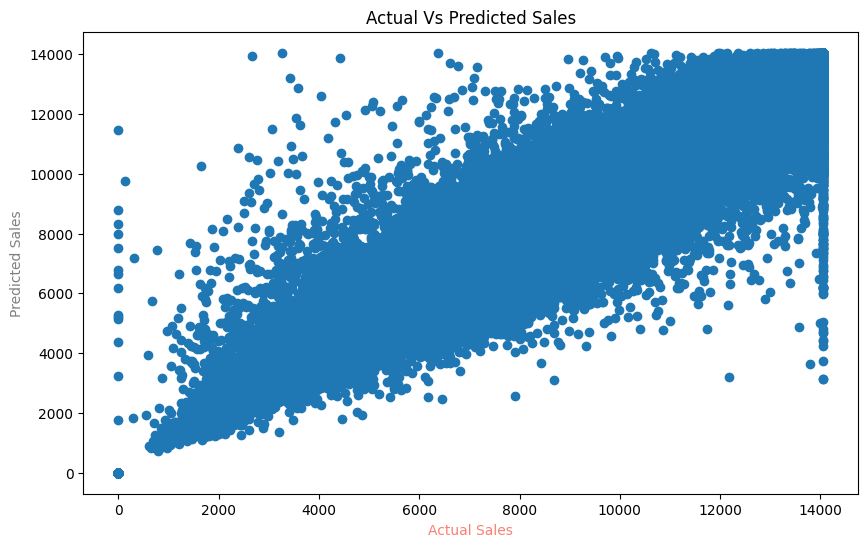

In [ ]:
# visualize the rendomforest model performance

# visualize the rendomforest model performance

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(y_val, y_pred, cmap ='plasma')
plt.xlabel('Actual Sales',color='salmon' )
plt.ylabel('Predicted Sales',color = 'gray')
plt.title('Actual Vs Predicted Sales')
plt.show()
plt.show()



Above scatter plot is visualizing positive correlation between actual and predicted sales.

In [ ]:
 # Make Prediction
 # Once the model is trained and evaluated , make predictions on the test dataset

In [ ]:
# Prepare test data before prediction
test_data = test.drop(columns=['Date'])
test_data = test.drop(columns=['StateHoliday']) # Isholiday have same featuers


In [ ]:
#test_data = test_data.drop(columns=['Id'])

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int32         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41088 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   SchoolHoliday              41088 non-null  int64         
 7   StoreType                  41088 non-null  int64         
 8   Assortment                 41088 non-null  int64         
 9   CompetitionDistance        41088 non-null  float64       
 10  CompetitionOpenSinceMonth  41088 non-null  float64       
 11  CompetitionOpenSinceYear   41088 non-null  float64       
 12  Prom

In [ ]:
test_data.isnull().sum()

,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,0
Promo,0
SchoolHoliday,0
StoreType,0
Assortment,0
CompetitionDistance,0


In [ ]:
test_data.shape

(41088, 22)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int32         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41088 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   SchoolHoliday              41088 non-null  int64         
 7   StoreType                  41088 non-null  int64         
 8   Assortment                 41088 non-null  int64         
 9   CompetitionDistance        41088 non-null  float64       
 10  CompetitionOpenSinceMonth  41088 non-null  float64       
 11  CompetitionOpenSinceYear   41088 non-null  float64       
 12  Prom

In [ ]:
test_data.describe()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsHoliday,IsWeekend
count,41088.000000,41088.000000,41088.000000,41088,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,...,41088.000000,41088.000000,41088.000000,41088.000000,4.108800e+04,41088.000000,41088.000000,41088.0,41088.000000,41088.000000
mean,20544.500000,555.899533,2.979167,2015-08-24 12:00:00,0.854361,0.395833,0.443487,1.252336,1.001168,-0.054476,...,0.580607,0.165400,0.160127,1.806075,1.502077e+00,8.354167,13.520833,34.645833,0.004381,0.291667
min,1.000000,1.000000,0.000000,2015-08-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.890745,...,0.000000,-0.760097,-1.001128,0.000000,1.502077e+00,8.000000,1.000000,31.0,0.000000,0.000000
25%,10272.750000,279.750000,1.000000,2015-08-12 18:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,-0.755997,...,0.000000,-0.760097,-1.001128,1.000000,1.502077e+00,8.000000,6.750000,33.0,0.000000,0.000000
50%,20544.500000,553.500000,3.000000,2015-08-24 12:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,-0.427791,...,1.000000,-0.172780,0.997130,2.000000,1.502077e+00,8.000000,12.500000,35.0,0.000000,0.000000
75%,30816.250000,832.250000,5.000000,2015-09-05 06:00:00,1.000000,1.000000,1.000000,3.000000,2.000000,0.344118,...,1.000000,1.262884,0.999118,3.000000,1.502077e+00,9.000000,19.250000,36.0,0.000000,1.000000
max,41088.000000,1115.000000,6.000000,2015-09-17 00:00:00,1.000000,1.000000,1.000000,3.000000,2.000000,1.994292,...,1.000000,2.437518,1.002101,3.000000,1.502077e+00,9.000000,31.000000,38.0,1.000000,1.000000
std,11861.228267,320.274496,2.015481,NaN,0.352748,0.489035,0.496802,1.397401,0.994741,0.903775,...,0.493466,1.055731,0.986966,1.128349,7.327561e-13,0.478266,8.448450,2.015481,0.066044,0.454535


In [ ]:
# save cleaned train data
#test_data.to_csv('test_data.csv', index=False) # Changed the file name

In [ ]:
#from google.colab import files
# To download test data after preprocessing
#files.download('test_data.csv')

In [ ]:
# Assuming 'Id' is not a feature for prediction:
# Select the relevant features for prediction, excluding 'Id'
relevant_features = X_train.columns  # Get the features used during training
test_data_for_prediction = test_data[relevant_features]

# Now, make predictions:
Predicted_sales = rf_regressor.predict(test_data_for_prediction)

print("Test Predictions:", Predicted_sales)

Test Predictions: [ 4310.68  7453.7   9192.84 ...  6539.15 14049.5   8352.48]


In [ ]:
# prepare final submission
# add predicted sales to the test data

test_data['Predicted_sales']=Predicted_sales
submission_df = test_data[['Id','Predicted_sales']]
submission_df.to_csv('Submission.csv',index=False)
print('Submission file created sucessfully!')



Submission file created sucessfully!


In [ ]:
submission_df.head(10)

,Id,Predicted_sales
0,1,4310.68
1,2,7453.70
2,3,9192.84
3,4,8253.28
4,5,7801.05
5,6,5945.88
6,7,7890.88
7,8,8371.64
8,9,6101.08
9,10,5782.21


In [ ]:
# save  submission dat
submission_df.to_csv('submission_df.csv',index=False)

In [ ]:
submission_df.describe()

,Id,Predicted_sales
count,41088.000000,41088.000000
mean,20544.500000,5909.502132
std,11861.228267,3333.195046
min,1.000000,0.000000
25%,10272.750000,4322.020000
50%,20544.500000,6037.575000
75%,30816.250000,7907.485000
max,41088.000000,14049.500000


In [ ]:
from google.colab import files
# Replace 'filename.csv' with your actual file name
files.download('submission_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Relative Importance')

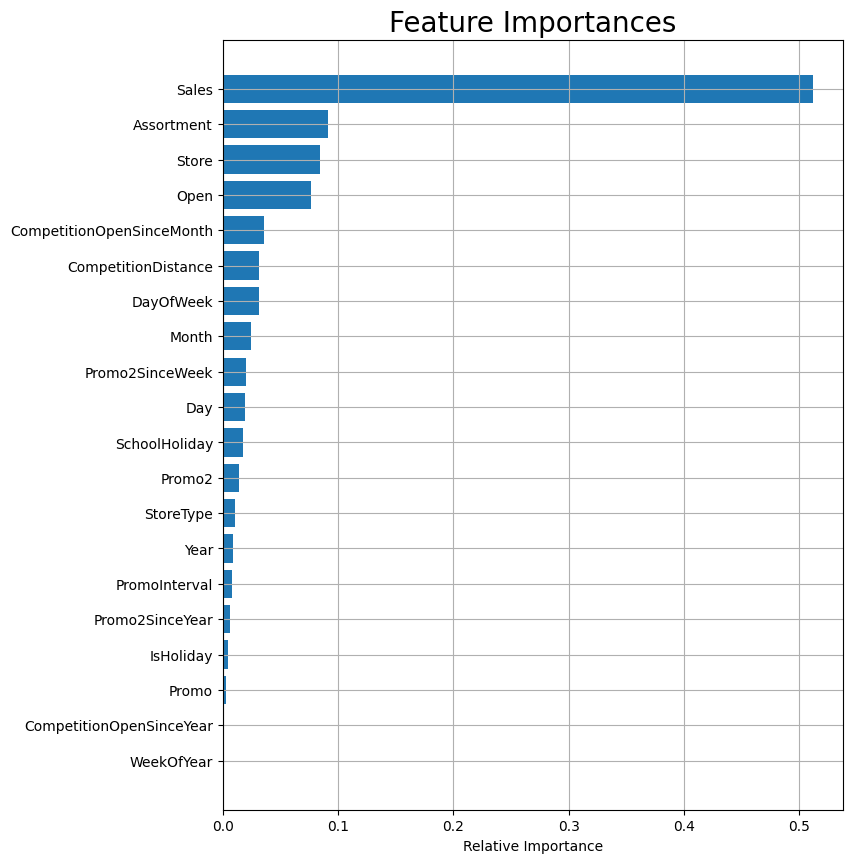

In [ ]:
# Global Explainability
# Plotting the barplot to determine which feature is contributing the most
features = train_data.columns
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.grid(zorder=0)
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')


In [ ]:
import joblib
# save the  model to local file system
joblib.dump(rf_regressor,'sales_predictions_model.joblib')

# load the model for later use

loaded_model = joblib.load('sales_predictions_model.joblib')



In [ ]:
# to download the model


from google.colab import files
files.download('sales_predictions_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
import logging
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Configure logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='model_joblib.log',
    filemode='w'
)
logger = logging.getLogger()

# Define the model path
model_path = '/content/sales_predictions_model.joblib'  # Define model path once

# Example: Load your actual data
#df = pd.read_csv('your_data.csv')

# Extracting features and target variable
X_train = df.drop(columns=['sales'])  # Assuming 'sales' is your target variable
y_train = df['sales']

# Assuming you have a separate test set (df_test)
X_test = df_test.drop(columns=['sales'])  # Example test data

# Define the training and prediction functions
def train_and_save_model(X_train, y_train, model_path):
    try:
        logger.info("Starting model training...")
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        logger.info("Model training completed.")

        # Save the model using joblib
        joblib.dump(model, model_path)  # Mention model_path only here
        logger.info(f"Model saved successfully at {model_path}")

        return model
    except Exception as e:
        logger.error(f"Error during training: {e}")
        raise

def load_and_predict(model_path, X_test):
    try:
        logger.info(f"Loading model from {model_path}...")  # Mention model_path only here
        model = joblib.load(model_path)  # Mention model_path only here
        logger.info("Model loaded successfully.")

        # Make predictions
        logger.info("Starting predictions...")
        predictions = model.predict(X_test)
        logger.info("Predictions completed.")
        return predictions
    except Exception as e:
        logger.error(f"Error during prediction: {e}")
        raise

# Main Execution
if __name__ == "__main__":
    # Train and save the model (model path is specified here)
    model = train_and_save_model(X_train, y_train, model_path)

    # Load and make predictions (model path is specified here)
    predictions = load_and_predict(model_path, X_test)
    logger.info(f"Predictions: {predictions}")
